In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy
import random
import cmath
import math

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft, ifft, fft2, ifft2
from scipy.optimize import minimize

## Autoencoder ptygenography

### Loading datasets

In [3]:
## import
import_train = np.load('MNIST_100_only3_train.npy')
import_test = np.load('MNIST_100_only3_test.npy')

## set current dataset
dataset = import_train
datatest = import_test
dataset_size = dataset[0]
nx = dataset.shape[1]
n = int(nx**2)

print("Shape current dataset using: ", dataset.shape)
print("Length of side: ", nx)

Shape current dataset using:  (6131, 10, 10)
Length of side:  10


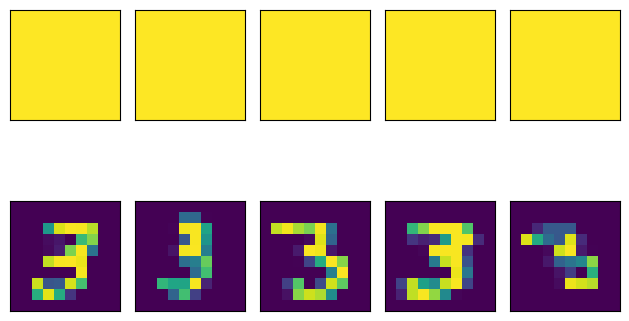

In [4]:
# show the data
ns = 5
fig, ax = plt.subplots(2,ns)

for i in range(ns):
    x = dataset[i]
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()

### Training parameters

In [13]:
## parameters relevant to training
EPOCHS = 50
dataset_size = dataset.shape[0]
sample_shape = 100
dataset_reshaped = np.reshape(dataset, (dataset_size, 100))
n = sample_shape # used later
nx = int(np.sqrt(sample_shape)) # one side of the 2D image
latent_dim = 10 # reduction of data 
k = latent_dim

print("Number of epochs", EPOCHS)
print("Dataset size: ", dataset_size)
print("Dimension of one sample: ", sample_shape)
print("Latent dimension: ", latent_dim)
print("Dimensions reshaped dataset: ", dataset_reshaped.shape)

# Note: cannot import weights decoder without keras tensorflow

Number of epochs 50
Dataset size:  6131
Dimension of one sample:  100
Latent dimension:  10
Dimensions reshaped dataset:  (6131, 100)


### Least squares signal optimization

In [10]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape
        
def objective(z, y, A, G, Gstar, w=1, lmbda = 0):
    """
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    """
    if len(y) != A.shape[0]:
        print("y and A don't match")
        return
    if len(z)//2 != G.shape[1]:
        print("z and G don't match")
        return
    if A.shape[1] != G.shape[0]:
        print("A and G don't match!")
        return
    
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]
    
    xc = G.eval(zc)
    Dx = G.jac(zc)
    Dxstar = Gstar.jac(zc)
    
    yp = A.eval(xc)
    Dy = A.jac(xc)

    DF = Dxstar.T@Dy.T + Dx.H@Dy.H

    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    #gradc  = Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc
    gradc  = DF@(yp - y) + (lmbda**2)*(w*w)*zc

    print("val", val)
    print("first element gradc", gradc[0]) # to see how much change occurs in the loop still
    
    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))
    
    return val, grad

def reconstruct(xtrue, A, G, Gstar, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # inference
    result = minimize(objective, x0=np.ones(2*k), args=(yobs, A, G, Gstar, w, lmbda), method='L-BFGS-B', jac=True, options={
        'maxiter': 10000,      # total outer iterations
        'maxls': 40,          # line search steps per iteration
        'ftol' : 1e-14,
        'gtol': 1e-14,         # gradient tolerance
        'disp': True          # print optimization log
    })
    
    # result
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)

    print("zhat", zhat)
    print("xhat", xhat)

    print("Result message:", result.message)
    print("Result status:", result.status)
    print("Function evals:", result.nfev)
    print("Jacobian evals:", result.njev)
    print("Final gradient norm:", np.linalg.norm(result.jac))
    
    # correct global phase
    #phi = np.mean(np.angle(xtrue/(xhat + 1e-16*np.ones_like(xhat)))) # avoid division by zero for bad reconstructions
    phi = np.mean(np.angle(xtrue/xhat)) 
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, yobs, result

def plot_result(xtrue, xhat):
    n  = len(xtrue)
    nx = int(np.sqrt(n))
    
    # plot results
    fig, ax = plt.subplots(2,2)

    ax[0,0].imshow(np.real(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[0,0].set_title(r'$\Re(x_{true})$')
    ax[1,0].imshow(np.imag(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[1,0].set_title(r'$\Im(x_{true})$')
    ax[0,1].imshow(np.real(xhat.reshape((nx,nx))),clim=[0,1])
    ax[0,1].set_title(r'$\Re(x_{est})$')
    ax[1,1].imshow(np.imag(xhat.reshape((nx,nx))),clim=[0,1])
    ax[1,1].set_title(r'$\Im(x_{est})$')

    fig.tight_layout()

In [11]:
def MaskedFourier(M):
    """
    Defined masked 2D fourier transform as linear operator.
    
    input:
        M - 3D array of size n x n x m containing m masks of size n x n
        
    out:
        A - linear operator representing the masked Fourier transforms
        
    
    """
    nx = M.shape[0]
    mx = M.shape[2]
    
    mv  = lambda x : fft2(M*(x.reshape((nx,nx,1))), axes=(0,1)).flatten()
    rmv = lambda y : nx*nx*np.sum(np.conj(M)*ifft2(y.reshape((nx,nx,mx)), axes=(0,1)),axis=2).flatten()
    A   = LinearOperator((mx*nx*nx, nx*nx), matvec=mv, rmatvec=rmv) # rmatvec is conjugate operation, so A^H * v
    
    return A

In [ ]:
# define forward operator with binary masks
mx = 100       # number of masks
m  = mx * n

M = np.random.randn(nx,nx,mx)
M[M<0]=0
M[M>0]=1

MF   = MaskedFourier(M)
print(MF.shape)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : (MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : (MF.H@((MF@x)*z)))

A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

(10000, 100)


In [14]:
#define generative models
I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))

Istar = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : np.zeros_like(z), rmatvec = lambda z : np.zeros_like(z)), shape=(n,n))

# define weights
w = 1

##### Individual reconstruction examples

val 1335909212.935284
first element gradc (15661331.656847408+15662785.035935447j)
val 987323125.5893532
first element gradc (12489034.868161138+12490385.984079838j)
val 222723856.4812098
first element gradc (4084426.0703955516+4085393.2649829746j)
val 82695057.05724837
first element gradc (1915977.6121379964+1916782.179099827j)
val 27533942.10002743
first element gradc (780136.7965185354+780837.1045872901j)
val 11930171.827757904
first element gradc (333443.19621164125+334133.643459647j)
val 7171504.512026026
first element gradc (139754.21803023384+140544.7646483772j)
val 5865800.228708396
first element gradc (60863.0105848027+61923.82223034445j)
val 5473301.047922031
first element gradc (29743.54949801811+31395.50180164737j)
val 5162657.884631018
first element gradc (16786.719343059973+19818.270551309768j)
val 3044670.693768313
first element gradc (7825.13798237706+10207.557643868746j)
val 260647309.25522986
first element gradc (-4005948.3548482372-4722819.793286301j)
val 2996255.503

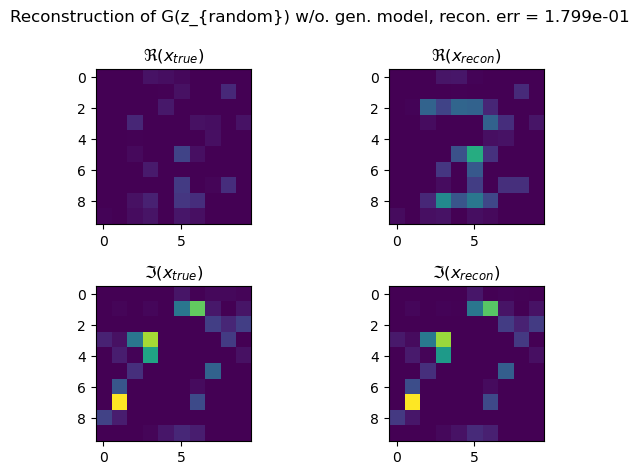

In [ ]:
# test generative model itself
sigma = 1e-5

xtrue = np.load('G(z)_ex2.npy') # a bad example

error, xhat_corr, yobs, _ = reconstruct(xtrue, A, I, Istar, w=1, sigma = sigma, lmbda = sigma)

print(f"Reconstruction error (sigma = {sigma}): ", error)

fig, ax = plt.subplots(2,2)

ax[0,0].imshow(np.real(xtrue.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{true})$')
ax[1,0].imshow(np.imag(xtrue.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{true})$')
ax[0,1].imshow(np.real(xhat_corr.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(x_{recon})$')
ax[1,1].imshow(np.imag(xhat_corr.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(x_{recon})$')

fig.suptitle(rf"Reconstruction of G(z_{{random}}) w/o. gen. model, recon. err = {error:.3e}")
fig.tight_layout()

### Experiments

In [16]:
# scan over noise levels with and without generative model on in-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

x_import = np.load('indistribution_ex.npy')

for i in range(len(sigmas)):
    for j in range(ns):
        xtrue = x_import[i,j,:] #here xtrue comes from the generative model

        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, I, Istar, w=1, sigma=sigmas[i], lmbda=sigmas[i])

val 1350698715.1641123
first element gradc (15739562.456093106+15738561.947489727j)
val 1000075858.6179054
first element gradc (12561809.07043686+12560767.12533827j)
val 227076518.92118612
first element gradc (4110864.6027373527+4109639.4069325696j)
val 85038802.64765224
first element gradc (1931121.6981486995+1929794.3898714453j)
val 28728913.04639646
first element gradc (788435.3963837494+786999.6482321951j)
val 12610128.961726345
first element gradc (338521.9203097385+336972.990594993j)
val 7590857.4422566
first element gradc (142772.02397609994+141054.6695311272j)
val 6173973.395893348
first element gradc (62185.2083475457+60177.38846109219j)
val 5770734.859060508
first element gradc (29375.363349489668+26808.25342855315j)
val 5571554.770491564
first element gradc (15764.01370272755+11897.3416683574j)
val 5025120.838830532
first element gradc (8387.218401044249-4262.835152763606j)
val 6882462.46571297
first element gradc (-56359.73926235411-216070.50993073347j)
val 4438564.68115813

In [91]:
for i in range(len(sigmas)):
    print(f"For noise level {sigmas[i]:.8e}  |  Mean error {np.mean(errors_i[i, :]):.6e}")


For noise level 1.00000000e-06  |  Mean error 3.669532e-06
For noise level 2.15443469e-05  |  Mean error 3.746108e-06
For noise level 4.64158883e-04  |  Mean error 3.921754e-06
For noise level 1.00000000e-02  |  Mean error 2.443651e-05
For noise level 2.15443469e-01  |  Mean error 4.909864e-04
For noise level 4.64158883e+00  |  Mean error 1.059822e-02
For noise level 1.00000000e+02  |  Mean error 2.264988e-01
For noise level 2.15443469e+03  |  Mean error 3.837532e-01
For noise level 4.64158883e+04  |  Mean error 1.000000e+00
For noise level 1.00000000e+06  |  Mean error 1.000000e+00


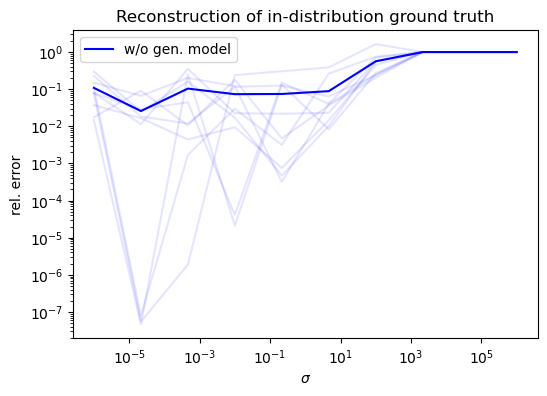

In [17]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('Reconstruction of in-distribution ground truth')
ax.legend()
#plt.savefig('MNIST_100_decoder_indistribution_lines.png', dpi=300)
plt.show()